<a href="https://colab.research.google.com/github/Fredherve/Asset-Management/blob/main/Partie_2_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1- Extraction prix call et put

In [61]:
import yfinance as yf
import pandas as pd

# Définir le symbole du sous-jacent
sous_jacent = "AMZN"

# Télécharger les informations sur les options
ticker = yf.Ticker(sous_jacent)

# Afficher les dates d'expiration disponibles
expiration_dates = ticker.options
print("Dates d'expiration disponibles :", expiration_dates)

# Initialiser une liste pour stocker les données
option_data = []

# Parcourir chaque date d'expiration
for date in expiration_dates:
  if pd.to_datetime(date) > pd.Timestamp.today():  # Assurez-vous que la date est dans le futur
    options_chain = ticker.option_chain(date)
    calls = options_chain.calls
    puts = options_chain.puts

    # Créer un tableau avec les informations demandées pour chaque option
    for idx, call in calls.iterrows():
        option_data.append({
            "Strike": call["strike"],
            "Maturité": date,
            "Prix Call": call["lastPrice"],
            "Volume Call": call["volume"],
            "Prix Put": None,  # Pas encore de prix pour le put
            "Volume Put": None,  # Pas encore de volume pour le put
        })

    for idx, put in puts.iterrows():
        option_data.append({
            "Strike": put["strike"],
            "Maturité": date,
            "Prix Call": None,  # Pas encore de prix pour le call
            "Volume Call": None,  # Pas encore de volume pour le call
            "Prix Put": put["lastPrice"],
            "Volume Put": put["volume"],
        })

# Créer un DataFrame à partir des données collectées
options_df = pd.DataFrame(option_data)

# Fusionner les lignes selon le Strike et la Maturité
options_df_merged = options_df.groupby(['Strike', 'Maturité'], as_index=False).agg({
    'Prix Call': 'first',
    'Volume Call': 'sum',
    'Prix Put': 'first',
    'Volume Put': 'sum',
})

# Filtrer les options en fonction du volume (Call ou Put) supérieur ou égal à 10
options_df_filtered = options_df_merged[
    (options_df_merged['Volume Call'] >= 8) | (options_df_merged['Volume Put'] >= 8)
]

# Trier les options selon la maturité (date)
options_df_filtered.loc[:, 'Maturité'] = pd.to_datetime(options_df_filtered['Maturité'])
options_df_filtered = options_df_filtered.sort_values(by=['Maturité','Strike'])

# Afficher le DataFrame filtré et trié
print("\nTableau des options filtrées (Volume Call ou Put >= 10) et triées par maturité :")
print(options_df_filtered.head(5))  # Afficher les 50 premières lignes pour la visualisation

# Optionnel : Sauvegarder le DataFrame filtré et trié en fichier CSV
options_df_filtered.to_csv("options_amzn_filtered_sorted_by_volume.csv", index=False)


Dates d'expiration disponibles : ('2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07', '2025-02-14', '2025-02-21', '2025-02-28', '2025-03-21', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17')

Tableau des options filtrées (Volume Call ou Put >= 10) et triées par maturité :
     Strike             Maturité  Prix Call  Volume Call  Prix Put  Volume Put
129   125.0  2025-01-24 00:00:00      96.58         30.0       NaN         0.0
198   145.0  2025-01-24 00:00:00      78.45          6.0      0.06        10.0
216   150.0  2025-01-24 00:00:00      73.34         11.0      0.01         1.0
234   155.0  2025-01-24 00:00:00      64.07          1.0      0.02        40.0
253   160.0  2025-01-24 00:00:00      59.39          5.0      0.01         9.0


In [62]:
print("\nVérification des valeurs manquantes dans les colonnes :")
print(options_df_filtered.isna().sum())  # Compter les valeurs manquantes par colonne


Vérification des valeurs manquantes dans les colonnes :
Strike          0
Maturité        0
Prix Call       8
Volume Call     0
Prix Put       50
Volume Put      0
dtype: int64


In [63]:
len(options_df_filtered)

604

### 2- volatilité implicite et graphe

In [64]:
S = round(ticker.history(period="1d")['Close'][-1], 3)   # Prix actuel du sous-jacent
print(f" le prix actuel du sous-jacent sans est {S}")

# Télécharger les données du rendement des bons du Trésor US à 3 mois pour le # Taux d'intérêt sans risque
treasury_data = yf.Ticker("^IRX")  # Symbole des bons du Trésor à 3 mois
r = round(treasury_data.history(period="1d")['Close'][-1] / 100, 3)
print(f" le taux sans risque est {r}")

<ipython-input-64-30c0f4bcd9f2>:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



 le prix actuel du sous-jacent sans est 220.66
 le taux sans risque est 0.042


<ipython-input-64-30c0f4bcd9f2>:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [65]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from scipy.optimize import root_scalar

# Fonction de Black-Scholes pour une option Call européenne
def black_scholes(S, K, T, r, sigma, type_):
    """
    Calcule le prix d'un call européen selon le modèle de Black-Scholes.
    :param S: Prix du sous-jacent
    :param K: Strike
    :param T: Temps jusqu'à maturité en années
    :param r: Taux d'intérêt sans risque
    :param sigma: Volatilité implicite
    :param type_: Type d'option ('call' ou 'put')
    :return: Prix du call
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    put_price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)

    if type_ == 'call':
        return call_price
    else:
        return put_price


# Fonction pour calculer la volatilité implicite
def implied_volatility(S, K, T, r, market_price, type_):
    """
    Estime la volatilité implicite à partir du prix de l'option call observé.
    :param S: Prix du sous-jacent
    :param K: Strike
    :param T: Temps jusqu'à maturité en années
    :param r: Taux d'intérêt sans risque
    :param market_price: Prix du call observé
    :return: Volatilité implicite estimée
    """
    # Fonction objectif pour la méthode numérique
    def objective(sigma):
        return black_scholes(S, K, T, r, sigma, type_) - market_price

    # Trouver la volatilité implicite qui rend la fonction objective proche de 0
    lower_bound, upper_bound = 0.000001, 1.0  # Les bornes peuvent être ajustées si nécessaire

    try:
        # Résoudre l'équation pour obtenir la volatilité implicite
        result = root_scalar(objective, method='brentq', bracket=[lower_bound, upper_bound], xtol=1e-20, maxiter=10000)
        if result.converged:
            return result.root
        else:
            return np.nan  # Si la méthode n'a pas convergé
    except ValueError as e:
        print(f"Erreur lors de la résolution : {e}")
        return np.nan


def calculate_implied_volatility(row, S, r, option_type):
    """
    Calcule la volatilité implicite pour une option (call ou put) à partir des données de la ligne.

    Parameters:
        row: pandas.Series - Ligne de données contenant les informations de l'option.
        S: float - Prix actuel du sous-jacent.
        r: float - Taux sans risque.
        option_type: str - Type de l'option ('call' ou 'put').

    Returns:
        float ou np.nan - Volatilité implicite ou NaN si les conditions ne sont pas remplies.
    """
    try:
        # Vérification des volumes
        volume_column = f"Volume {option_type.capitalize()}"
        price_column = f"Prix {option_type.capitalize()}"

        if pd.notna(row[volume_column]) and row[volume_column] > 7:
            # Calcul de la maturité en années
            maturity_days = (pd.to_datetime(row['Maturité']) - pd.Timestamp.today()).days
            if maturity_days > 0:  # Assurez-vous que la maturité est dans le futur
                T = maturity_days / 365
                return implied_volatility(S, row['Strike'], T, r, row[price_column], type_=option_type)
        return np.nan
    except Exception as e:
        print(f"Erreur lors du calcul de la volatilité implicite ({option_type}) pour la ligne {row.name}: {e}")
        return np.nan

In [66]:
# Calcul de la volatilité implicite pour les calls
options_df_filtered['Volatilité implicite_call'] = options_df_filtered.apply(
    lambda row: calculate_implied_volatility(row, S, r, 'call'),
    axis=1
)

# Calcul de la volatilité implicite pour les puts
options_df_filtered['Volatilité implicite_put'] = options_df_filtered.apply(
    lambda row: calculate_implied_volatility(row, S, r, 'put'),
    axis=1
)

Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur lors de la résolution : f(a) and f(b) must have different signs
Erreur

In [67]:
# Optionnel : Sauvegarder le DataFrame avec la volatilité implicite en fichier CSV
#options_df_filtered.to_csv("options_amzn_with_volatility.csv", index=False)

In [68]:
print(options_df_filtered.isna().sum())

Strike                         0
Maturité                       0
Prix Call                      8
Volume Call                    0
Prix Put                      50
Volume Put                     0
Volatilité implicite_call    190
Volatilité implicite_put     237
dtype: int64


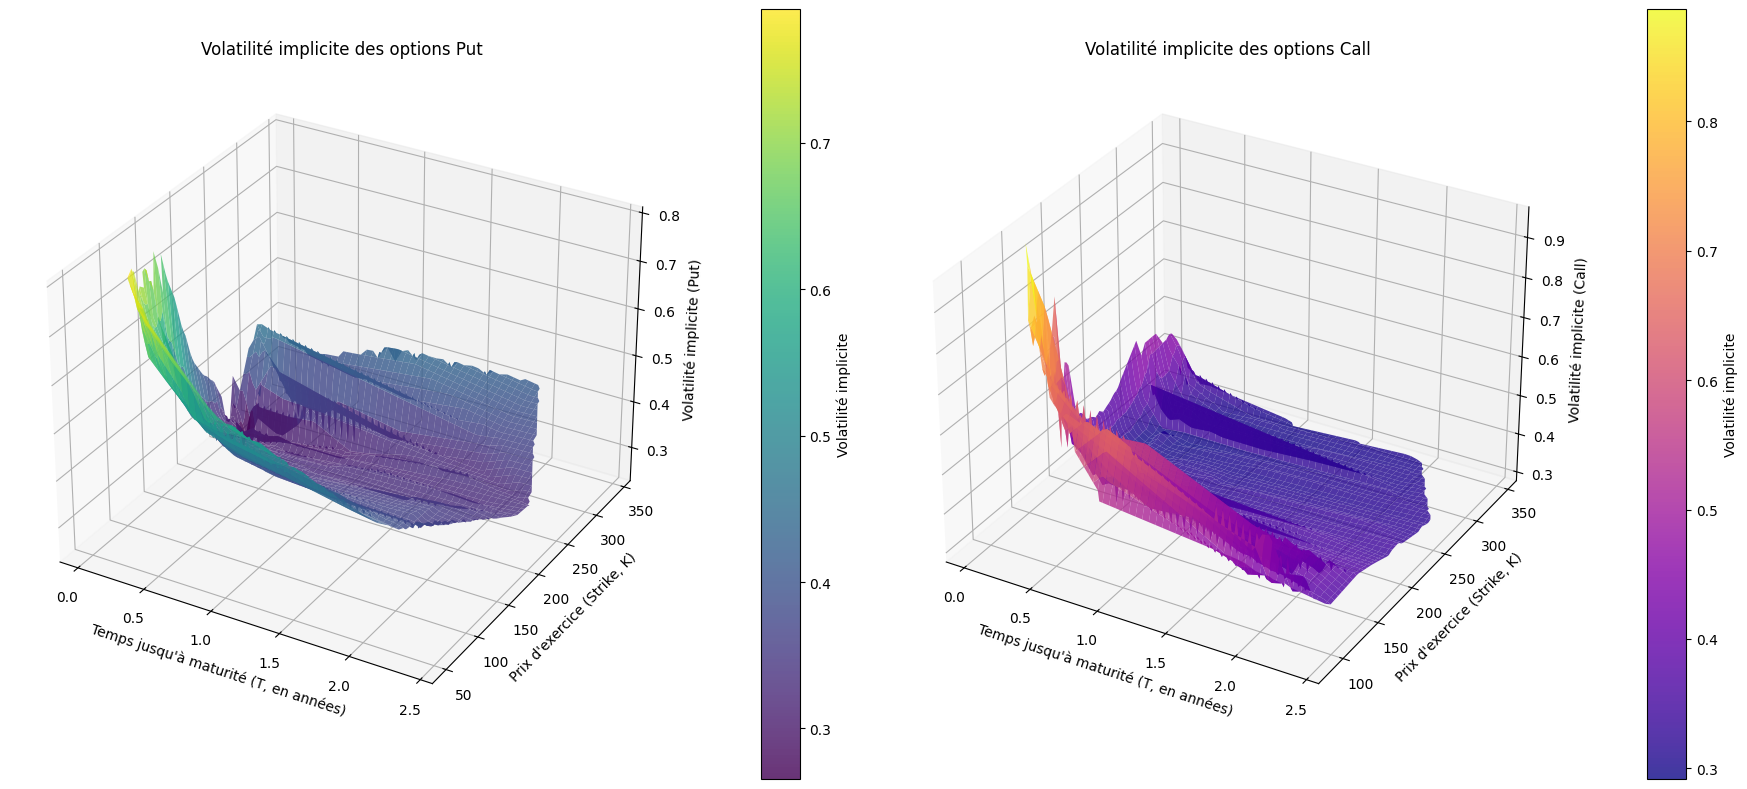

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Filtrer les données pour lesquelles la volatilité implicite n'est pas NaN (put et call)
df_plot_put = options_df_filtered.dropna(subset=['Volatilité implicite_put'])
df_plot_call = options_df_filtered.dropna(subset=['Volatilité implicite_call'])

# Fonction pour traiter et interpoler les données
def prepare_data(df, vol_col):
    T_values = (pd.to_datetime(df['Maturité']) - pd.Timestamp.today()).dt.days / 365
    K_values = df['Strike']
    vol_values = df[vol_col]

    # Filtrer pour enlever les maturités inférieures à 7 jours
    valid_indices = T_values > 7 / 365
    T_values = T_values[valid_indices]
    K_values = K_values[valid_indices]
    vol_values = vol_values[valid_indices]

    # Ensure T_values, K_values and vol_values are numeric
    T_values = pd.to_numeric(T_values, errors='coerce')
    K_values = pd.to_numeric(K_values, errors='coerce')
    vol_values = pd.to_numeric(vol_values, errors='coerce')

    # Créer une grille pour l'interpolation
    T_grid, K_grid = np.meshgrid(
        np.linspace(T_values.min(), T_values.max(), 100),  # Grille pour T
        np.linspace(K_values.min(), K_values.max(), 100)  # Grille pour K
    )

    # Interpoler les valeurs de volatilité implicite
    vol_grid = griddata(
        (T_values.values, K_values.values), vol_values.values, #.values is added to extract the underlying numpy array
        (T_grid, K_grid),
        method='linear'  # Interpolation linéaire
    )
    return T_grid, K_grid, vol_grid

# Préparer les données pour le put
T_grid_put, K_grid_put, vol_grid_put = prepare_data(df_plot_put, 'Volatilité implicite_put')

# Préparer les données pour le call
T_grid_call, K_grid_call, vol_grid_call = prepare_data(df_plot_call, 'Volatilité implicite_call')

# Créer la figure avec deux sous-graphiques
fig = plt.figure(figsize=(18, 8))

# Graphique pour le put
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(
    T_grid_put, K_grid_put, vol_grid_put,
    cmap='viridis', edgecolor='none', alpha=0.8
)
ax1.set_xlabel('Temps jusqu\'\u00e0 maturit\u00e9 (T, en ann\u00e9es)')
ax1.set_ylabel('Prix d\'exercice (Strike, K)')
ax1.set_zlabel('Volatilit\u00e9 implicite (Put)')
ax1.set_title('Volatilit\u00e9 implicite des options Put')
cbar1 = fig.colorbar(surf1, ax=ax1, pad=0.1)
cbar1.set_label('Volatilit\u00e9 implicite')

# Graphique pour le call
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(
    T_grid_call, K_grid_call, vol_grid_call,
    cmap='plasma', edgecolor='none', alpha=0.8
)
ax2.set_xlabel('Temps jusqu\'\u00e0 maturit\u00e9 (T, en ann\u00e9es)')
ax2.set_ylabel('Prix d\'exercice (Strike, K)')
ax2.set_zlabel('Volatilit\u00e9 implicite (Call)')
ax2.set_title('Volatilit\u00e9 implicite des options Call')
cbar2 = fig.colorbar(surf2, ax=ax2, pad=0.1)
cbar2.set_label('Volatilit\u00e9 implicite')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


<ipython-input-70-b5bb40939e57>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



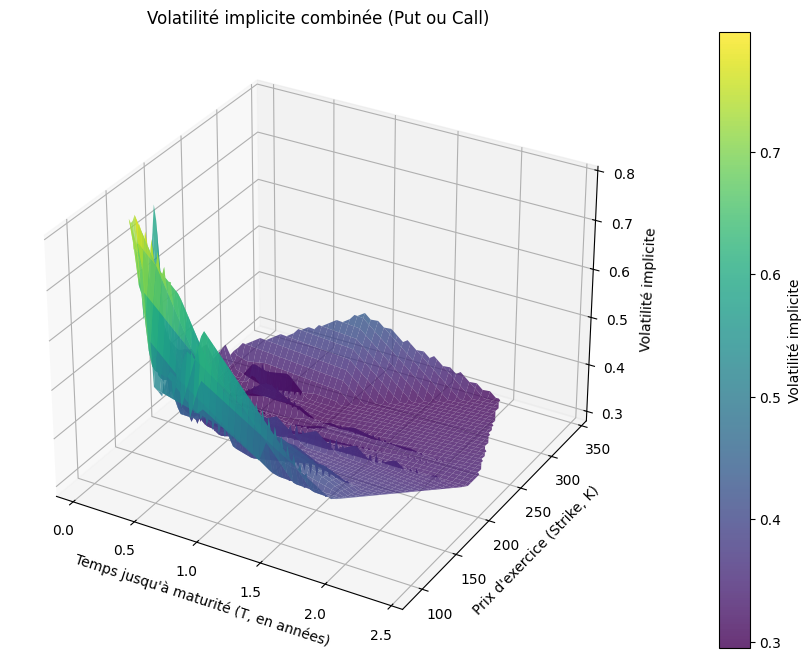

In [70]:
# Filtrer les données où les volatilités implicites et volumes sont valides
df_plot = options_df_filtered.dropna(subset=['Volatilité implicite_put', 'Volatilité implicite_call', 'Volume Put', 'Volume Call']) # Use original column names with spaces

# Créer une nouvelle colonne pour choisir la volatilité en fonction des volumes
df_plot['Volatilité implicite_combined'] = np.where(
    df_plot['Volume Put'] > df_plot['Volume Call'], # Use original column names with spaces
    df_plot['Volatilité implicite_put'],  # Si le volume du put est supérieur, prendre la volatilité du put
    df_plot['Volatilité implicite_call']  # Sinon, prendre la volatilité du call
)

# Fonction pour traiter et interpoler les données
def prepare_data(df):
    T_values = (pd.to_datetime(df['Maturité']) - pd.Timestamp.today()).dt.days / 365
    K_values = df['Strike']
    vol_values = df['Volatilité implicite_combined']

    # Filtrer pour enlever les maturités inférieures à 7 jours
    valid_indices = T_values > 7 / 365
    T_values = T_values[valid_indices]
    K_values = K_values[valid_indices]
    vol_values = vol_values[valid_indices]

    # Créer une grille pour l'interpolation
    T_grid, K_grid = np.meshgrid(
        np.linspace(T_values.min(), T_values.max(), 100),  # Grille pour T
        np.linspace(K_values.min(), K_values.max(), 100)  # Grille pour K
    )

    # Interpoler les valeurs de volatilité implicite
    vol_grid = griddata(
        (T_values.values, K_values.values), vol_values.values,
        (T_grid, K_grid),
        method='linear'  # Interpolation linéaire
    )
    return T_grid, K_grid, vol_grid

# Préparer les données combinées
T_grid, K_grid, vol_grid = prepare_data(df_plot)

# Créer la figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface
surf = ax.plot_surface(
    T_grid, K_grid, vol_grid,
    cmap='viridis', edgecolor='none', alpha=0.8
)

# Ajouter des labels et un titre
ax.set_xlabel('Temps jusqu\'\u00e0 maturit\u00e9 (T, en ann\u00e9es)')
ax.set_ylabel('Prix d\'exercice (Strike, K)')
ax.set_zlabel('Volatilit\u00e9 implicite')
ax.set_title('Volatilit\u00e9 implicite combinée (Put ou Call)')

# Ajouter une barre de couleurs
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Volatilit\u00e9 implicite')

# Afficher le graphique
plt.show()


### 3- pricer un call/put

In [71]:
def estimate_volatility(df, strike, maturity, option_type):
    """
    Interpole la volatilité implicite pour une maturité et un strike donnés à partir d'un DataFrame.

    :param df: DataFrame contenant les colonnes 'maturities', 'strikes', et 'volatilities'
    :param strike: Strike pour lequel interpoler la volatilité
    :param maturity: Maturité pour laquelle interpoler la volatilité (en années)
    :param option_type: Type d'option ('call' ou 'put')
    :return: Volatilité implicite interpolée
    """

    # Préparer les données de volatilité en fonction du type d'option
    maturities = ((pd.to_datetime(df_plot['Maturité']) - pd.Timestamp.today()).dt.days / 365).values
    strikes = df['Strike'].values
    if option_type == 'put':
        volatilities = df['Volatilité implicite_put'].values
    elif option_type == 'call':
        volatilities = df['Volatilité implicite_call'].values
    else:
        raise ValueError("Le type d'option doit être 'call' ou 'put'.")

    # Supprimer les valeurs NaN pour éviter des problèmes d'interpolation
    valid_idx = ~np.isnan(volatilities)
    maturities = maturities[valid_idx]
    strikes = strikes[valid_idx]
    volatilities = volatilities[valid_idx]

    # Combinez maturities et strikes pour former des points 2D
    points = np.array(list(zip(maturities, strikes)))

    # Effectuer l'interpolation
    implied_vol = griddata(points, volatilities, (maturity, strike), method='linear')

    # Vérifier si l'interpolation a échoué
    if np.isnan(implied_vol):
        raise ValueError("Interpolation échouée : vérifiez que les données couvrent bien la maturité et le strike demandés.")

    return implied_vol

#### Exemple d'utilisation

In [72]:
K = 190 # un strike donné
T = 1.5  # une maturité donnée
type_option = 'call'
vol = estimate_volatility(df_plot, K, T, type_option)
price_estimate = black_scholes(S, K, T, r, vol, type_option)
print(price_estimate)

58.804576233545035


### 4- Calculer les grecques et les grapher en fonction de K ou de T

In [73]:
from scipy.stats import norm

def calculate_greeks(S, K, T, r, option_type):
    """
    Calcule tous les grecs pour une option européenne.

    :param S: Prix du sous-jacent
    :param K: Strike
    :param T: Maturité en années
    :param r: Taux sans risque
    :param sigma: Volatilité
    :param option_type: Type de l'option ("call" ou "put")
    :return: Delta, Gamma, Theta, Vega, Rho
    """
    sigma = estimate_volatility(df_plot, K, T, option_type)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Delta
    delta = norm.cdf(d1) if option_type == "call" else norm.cdf(d1) - 1
    # Gamma
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    # Vega
    vega = S * norm.pdf(d1) * np.sqrt(T)
    # Theta
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) -
             r * K * np.exp(-r * T) * (norm.cdf(d2) if option_type == "call" else norm.cdf(-d2)))
    # Rho
    rho = (K * T * np.exp(-r * T) * norm.cdf(d2) if option_type == "call"
           else -K * T * np.exp(-r * T) * norm.cdf(-d2))

    return delta, gamma, theta, vega, rho


#### Exemple d'utilisation

In [74]:
# avec les valeurs données plus haut
calculate_greeks(S, K, T, r, 'put')

(-0.23297639589986674,
 0.0034395933212157804,
 -11.852941618169089,
 82.65194270732643,
 -99.59059959930168)

In [75]:
def plot_greeks(S, K_values, T_values, r, option_type, greek_type):
    """
    Trace les grecques en fonction du strike (K) pour différentes maturités (T).

    :param S: Prix du sous-jacent
    :param K_values: Liste des strikes
    :param T_values: Liste des maturités
    :param r: Taux sans risque
    :param option_type: Type de l'option ("call" ou "put")
    :param greek_type: Type de la grec (delta, gamma, theta, vega, rho)
    """
    plt.figure(figsize=(12, 8))

    for T in T_values:
        results = {
            "deltas": [],
            "gammas": [],
            "thetas": [],
            "vegas": [],
            "rhos": []
            }
        for K in K_values:
            delta, gamma, theta, vega, rho = calculate_greeks(S, K, T, r, option_type)
            results["deltas"].append(delta)
            results["gammas"].append(gamma)
            results["thetas"].append(theta)
            results["vegas"].append(vega)
            results["rhos"].append(rho)

        plt.plot(K_values, results[f"{str(greek_type)}s"], label=f"{str(greek_type)} (T={T})")


    plt.title(f"{str(greek_type)} en fonction du strike (K)")
    plt.xlabel("Strike (K)")
    plt.ylabel(f"Valeur de {str(greek_type)}")
    plt.legend(title=f"Légende : {str(greek_type)} en fonction de T")
    plt.grid()
    plt.show()

#### Exemple d'utilisation

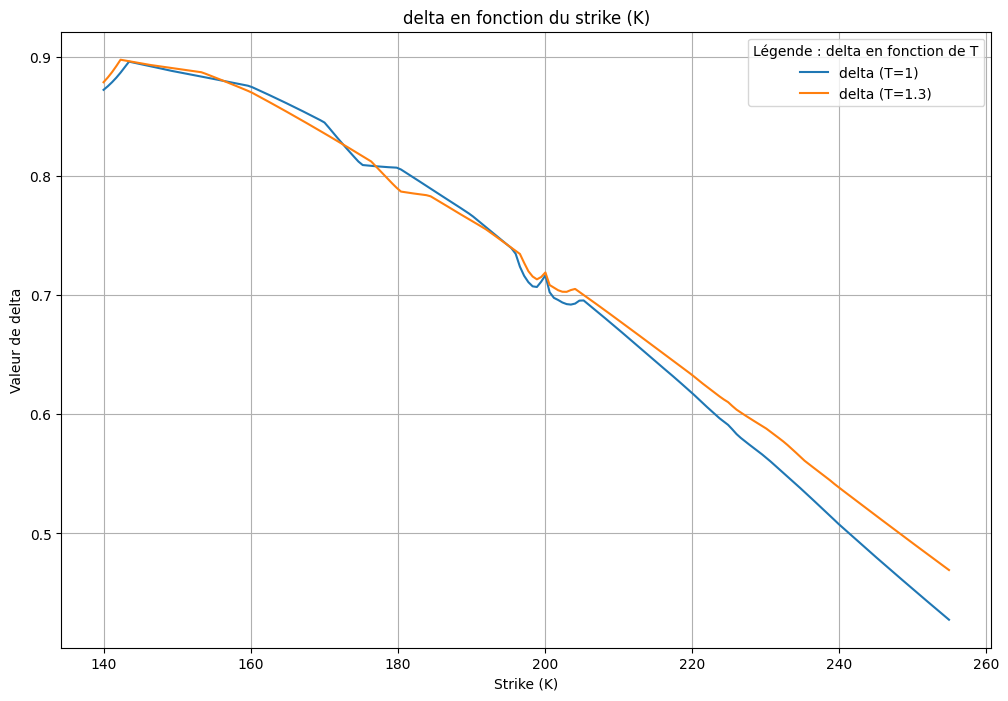

In [76]:
plot_greeks(S, np.linspace(140, 255, num=200), [1, 1.3], r, 'call', 'delta')

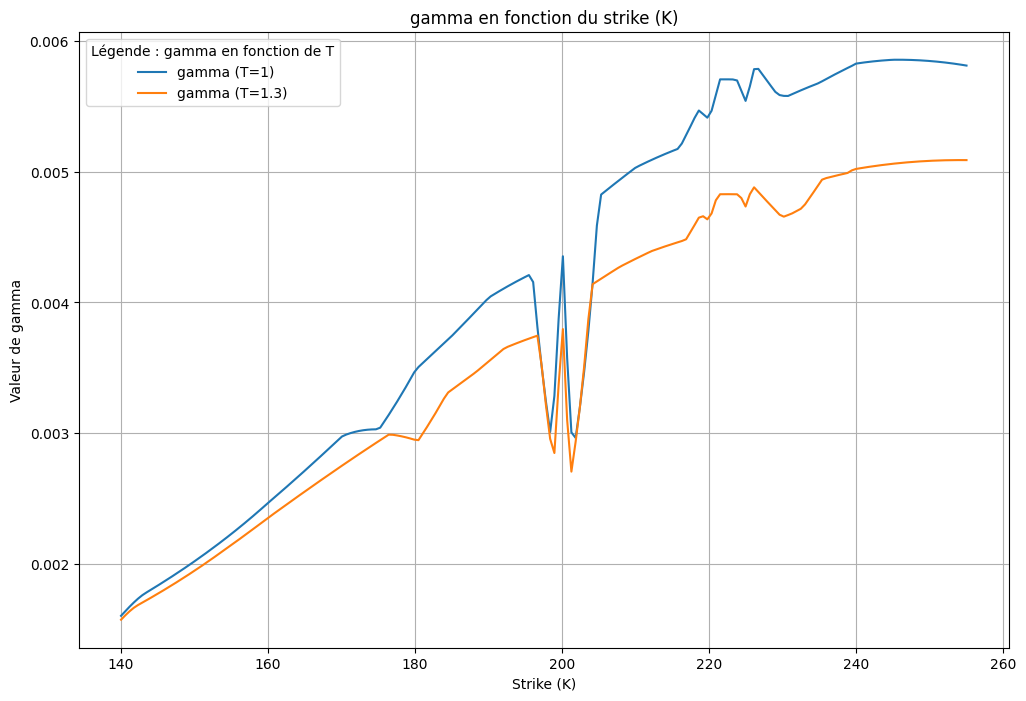

In [77]:
plot_greeks(S, np.linspace(140, 255, num=200), [1, 1.3], r, 'call', 'gamma')

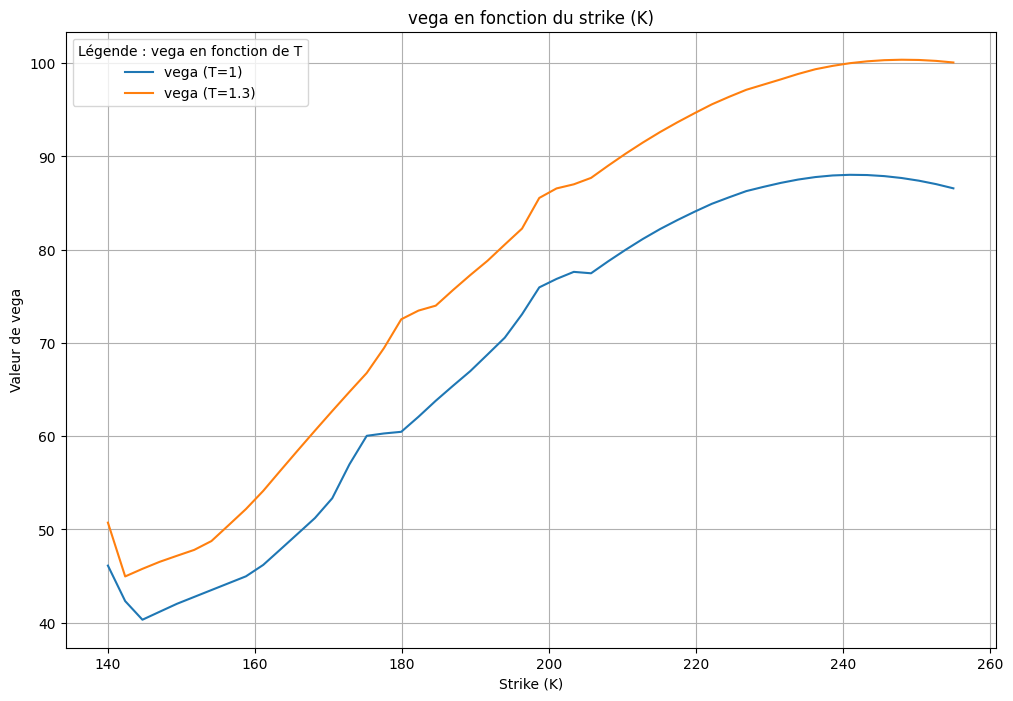

In [78]:
plot_greeks(S, np.linspace(140, 255), [1, 1.3], r, 'call', 'vega')

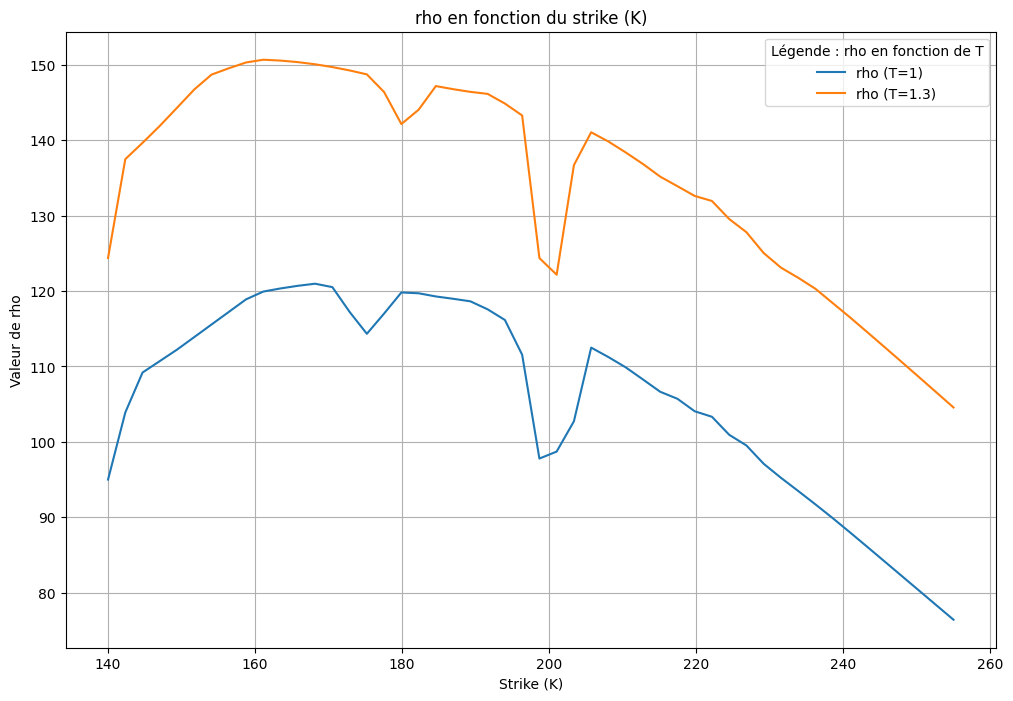

In [79]:
plot_greeks(S, np.linspace(140, 255), [1, 1.3], r, 'call', 'rho')

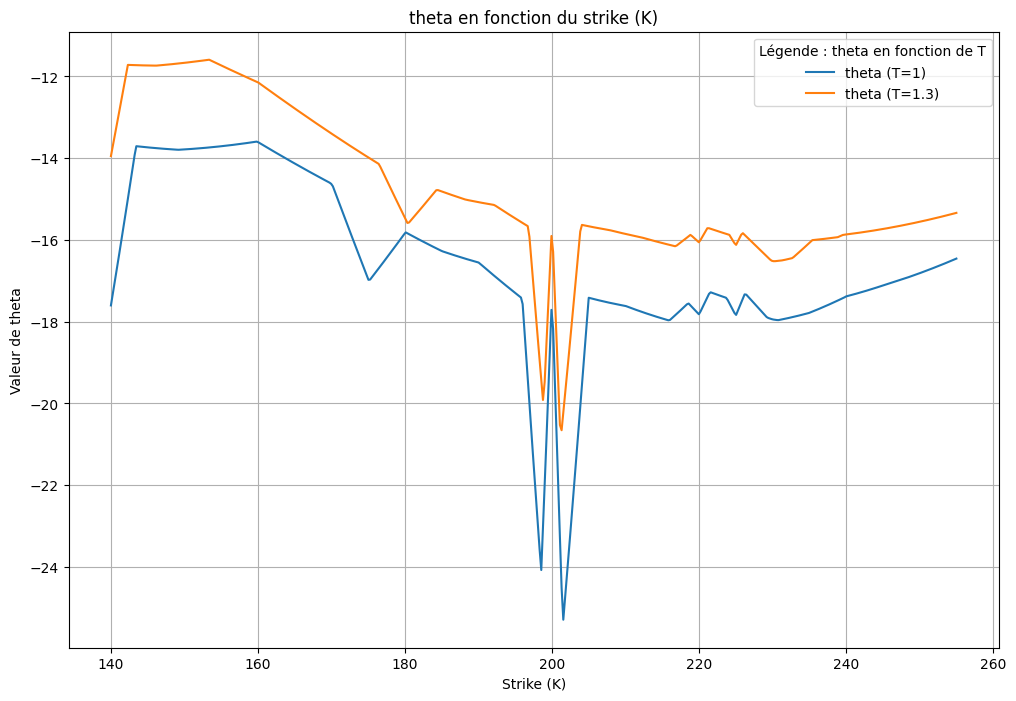

In [80]:
plot_greeks(S, np.linspace(140, 255, num=500), [1, 1.3], r, 'call', 'theta')

### 5- Simulation de trajectoires BS avec monte carlo et princing d'une option asiatique.

In [81]:
def price_asian_option(S, K, T, r, sigma, n_simulations, n_steps, show_trajectories=10):
    """
    Simule les trajectoires et calcule le prix d'une option asiatique avec affichage de quelques trajectoires.
    """
    dt = T / n_steps
    trajectories = np.zeros((n_simulations, n_steps + 1))
    trajectories[:, 0] = S

    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_simulations)
        trajectories[:, t] = trajectories[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Affichage de quelques trajectoires
    plt.figure(figsize=(10, 6))
    for i in range(min(show_trajectories, n_simulations)):  # Afficher jusqu'à "show_trajectories" trajectoires
        plt.plot(np.linspace(0, T, n_steps + 1), trajectories[i], alpha=0.7)
    plt.title("Trajectoires simulées du sous-jacent (Modèle de Black-Scholes)")
    plt.xlabel("Temps (années)")
    plt.ylabel("Prix du sous-jacent")
    plt.grid()
    plt.show()

    # Calcul du prix moyen de l'option asiatique
    S_avg = np.mean(trajectories[:, 1:], axis=1)

    # Calcul des payoffs
    payoff_call = np.maximum(S_avg - K, 0)
    payoff_put = np.maximum(K - S_avg, 0)

    # Actualisation des payoffs
    call_price = np.exp(-r * T) * np.mean(payoff_call)
    put_price = np.exp(-r * T) * np.mean(payoff_put)

    return call_price, put_price

<ipython-input-82-a7eec415ee84>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



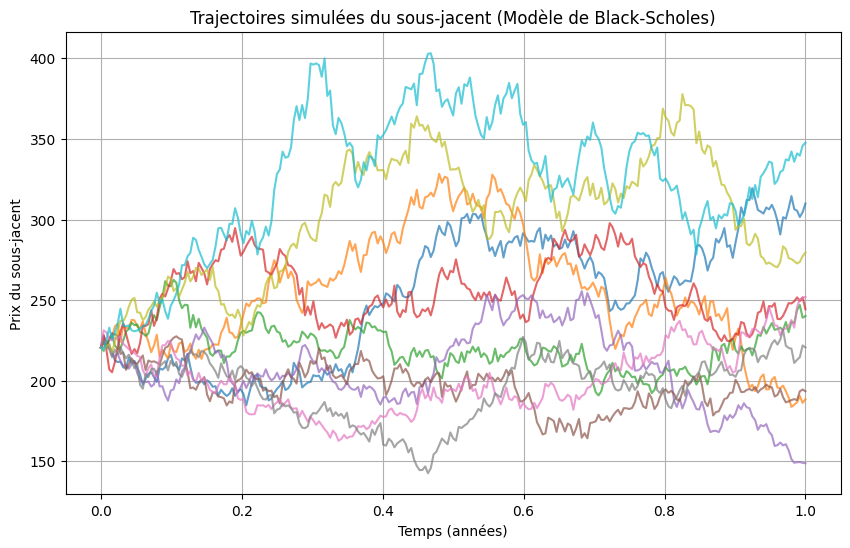

Prix Call asiatique (Monte Carlo): 45.86
Prix Put asiatique (Monte Carlo): 2.60


In [82]:
#à voir ce qu'on prend pour la maturité et le strike (paramètre à changer dans l'interface)
S = round(ticker.history(period="1d")['Close'][-1], 3)
K = 180
T = 1
r = 0.042
sigma = estimate_volatility(df_plot, K, T, "call")

# Paramètres de simulation
n_simulations = 10000
#on estime le prix d'une option en regardant 10,000 scénarios différents d'évolution possible du prix de l'actif sous-jacent (on peut le faire varier dans l'interface également et comparer les perf)

n_steps = 252
#Pour une option asiatique, le payoff dépend de la moyenne arithmétique des prix observés à des intervalles réguliers pendant la durée de vie de l'option
#ce param est donc très important à optimiser également (à faire varier sur l'interface)

# Appel de la fonction
call_price, put_price = price_asian_option(S, K, T, r, sigma, n_simulations, n_steps)

print(f"Prix Call asiatique (Monte Carlo): {call_price:.2f}")
print(f"Prix Put asiatique (Monte Carlo): {put_price:.2f}")

#### Avec option barrière

In [83]:
def price_barrier_option(S, K, T, r, sigma, n_simulations, n_steps, barrier, option_type, barrier_type, show_trajectories=10):
    """
    Prix des options barrières (up-and-out, up-and-in, down-and-out, down-and-in) via Monte Carlo.

    Arguments:
    - S: Prix initial du sous-jacent
    - K: Strike (prix d'exercice)
    - T: Maturité (en années)
    - r: Taux sans risque
    - sigma: Volatilité
    - n_simulations: Nombre de simulations Monte Carlo
    - n_steps: Nombre de pas de temps
    - barrier: Niveau de la barrière
    - option_type: "call" ou "put"
    - barrier_type: "up-and-out", "up-and-in", "down-and-out", "down-and-in"
    - show_trajectories: Nombre de trajectoires à afficher

    Retourne:
    - Prix de l'option barrière.
    """
    dt = T / n_steps
    trajectories = np.zeros((n_simulations, n_steps + 1))
    trajectories[:, 0] = S

    barrier_hit = np.zeros(n_simulations, dtype=bool)

    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_simulations)
        trajectories[:, t] = trajectories[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Suivre si la barrière est franchie
        if "up" in barrier_type:
            barrier_hit |= trajectories[:, t] >= barrier
        elif "down" in barrier_type:
            barrier_hit |= trajectories[:, t] <= barrier

    # Affichage de quelques trajectoires
    plt.figure(figsize=(10, 6))
    for i in range(min(show_trajectories, n_simulations)):
        plt.plot(np.linspace(0, T, n_steps + 1), trajectories[i], alpha=0.7)
    plt.axhline(y=barrier, color='red', linestyle='--', label='Barrière')
    plt.title("Trajectoires simulées avec Barrière")
    plt.xlabel("Temps (années)")
    plt.ylabel("Prix du sous-jacent")
    plt.legend()
    plt.grid()
    plt.show()

    # Déterminer le payoff selon le type d'option barrière
    if barrier_type == "up-and-out":
        valid = ~barrier_hit
    elif barrier_type == "up-and-in":
        valid = barrier_hit
    elif barrier_type == "down-and-out":
        valid = ~barrier_hit
    elif barrier_type == "down-and-in":
        valid = barrier_hit
    else:
        raise ValueError("Type de barrière non reconnu.")

    # Calcul des payoffs
    ST = trajectories[:, -1]
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("Type d'option non reconnu. Utiliser 'call' ou 'put'.")

    # Considérer seulement les scénarios où la barrière est valide
    payoff *= valid

    # Actualisation des payoffs
    option_price = np.exp(-r * T) * np.mean(payoff)

    return option_price

<ipython-input-84-f7cd085af511>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-84-f7cd085af511>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



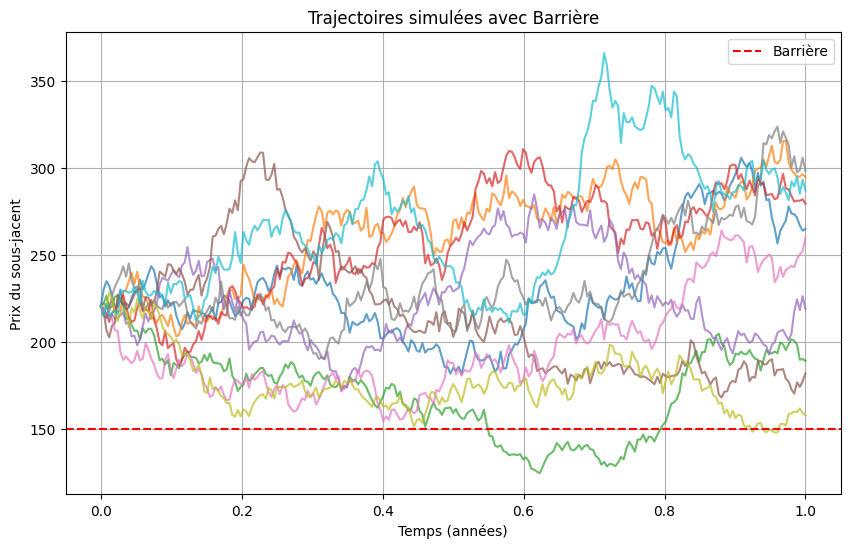

Prix de l'option barrière (up-and-out, call): 0.00


In [84]:
# Paramètres de l'option
S = round(ticker.history(period="1d")['Close'][-1], 3)
K = 180
T = 1
r = round(treasury_data.history(period="1d")['Close'][-1] / 100, 3)
sigma = estimate_volatility(df_plot, K, T, "call")


n_simulations = 10000
n_steps = 252
barrier = 150  # Niveau de la barrière
option_type = "call" #Type d'option
barrier_type = "up-and-out"  # Type de barrière

# Calcul du prix de l'option barrière
price = price_barrier_option(S, K, T, r, sigma, n_simulations, n_steps, barrier, option_type, barrier_type)
print(f"Prix de l'option barrière ({barrier_type}, {option_type}): {price:.2f}")

## Création d'un DASH pour présenter les résultats

In [85]:
! pip install dash
! pip install dash-bootstrap-components
! pip install plotly

In [86]:
df_plot_put = options_df_filtered.dropna(subset=['Volatilité implicite_put'])
df_plot_call = options_df_filtered.dropna(subset=['Volatilité implicite_call'])

# Préparer les données pour l'interpolation
def prepare_data(df, vol_col):
    T_values = (pd.to_datetime(df['Maturité']) - pd.Timestamp.today()).dt.days / 365
    K_values = df['Strike']
    vol_values = df[vol_col]

    # Filtrer pour enlever les maturités inférieures à 7 jours
    valid_indices = T_values > 7 / 365
    T_values = T_values[valid_indices]
    K_values = K_values[valid_indices]
    vol_values = vol_values[valid_indices]

    # Créer une grille pour l'interpolation
    T_grid, K_grid = np.meshgrid(
        np.linspace(T_values.min(), T_values.max(), 100),  # Grille pour T
        np.linspace(K_values.min(), K_values.max(), 100)  # Grille pour K
    )

    # Interpoler les valeurs de volatilité implicite
    vol_grid = griddata(
        (T_values.values, K_values.values), vol_values.values,
        (T_grid, K_grid),
        method='linear'  # Interpolation linéaire
    )
    return T_grid, K_grid, vol_grid

# Préparer les données pour le put et le call
T_grid_put, K_grid_put, vol_grid_put = prepare_data(df_plot_put, 'Volatilité implicite_put')
T_grid_call, K_grid_call, vol_grid_call = prepare_data(df_plot_call, 'Volatilité implicite_call')

# Créer une nouvelle colonne pour la volatilité combinée
df_plot = options_df_filtered.dropna(subset=['Volatilité implicite_put', 'Volatilité implicite_call', 'Volume Put', 'Volume Call'])
df_plot['Volatilité implicite_combined'] = np.where(
    df_plot['Volume Put'] > df_plot['Volume Call'],
    df_plot['Volatilité implicite_put'],
    df_plot['Volatilité implicite_call']
)

# Préparer les données combinées
T_grid_combined, K_grid_combined, vol_grid_combined = prepare_data(df_plot, 'Volatilité implicite_combined')

<ipython-input-86-44be61edb741>:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
from scipy.spatial import cKDTree

def prepare_data_for_interpolation(df, vol_col, K_target, T_target):
    """
    Prépare les 4 points d'interpolation les plus proches pour une valeur donnée de K (strike) et T (maturité).

    Arguments:
    - df : DataFrame contenant les données de marché.
    - vol_col : Nom de la colonne de volatilité dans le DataFrame.
    - K_target : Strike cible pour l'interpolation.
    - T_target : Maturité cible (en années) pour l'interpolation.

    Retourne:
    - points : Liste de 4 tuples (K, T, volatilité) correspondant aux points d'interpolation les plus proches.
    """
    # Calculer les maturités en années
    T_values = (pd.to_datetime(df['Maturité']) - pd.Timestamp.today()).dt.days / 365
    K_values = df['Strike']
    vol_values = df[vol_col]

    # Filtrer les données valides (maturité > 7 jours)
    valid_indices = T_values > 7 / 365
    T_values = T_values[valid_indices].values
    K_values = K_values[valid_indices].values
    vol_values = vol_values[valid_indices].values

    # Construire un espace (K, T)
    points = np.column_stack((K_values, T_values))

    # Utiliser un arbre k-d pour trouver les 4 points les plus proches
    tree = cKDTree(points)
    distances, indices = tree.query([K_target, T_target], k=4)

    # Extraire les 4 points correspondants
    interpolation_points = [(K_values[i], T_values[i], vol_values[i]) for i in indices]

    return interpolation_points

In [88]:
def plot_greeks(S, K_values, T_values, r, option_type, greek_type):
    """
    Trace les Greeks en fonction du strike et des maturités.
    """
    fig = go.Figure()

    for T in T_values:
        greek_values = []
        for K in K_values:
            # Calculer tous les Greeks
            delta, gamma, theta, vega, rho = calculate_greeks(S, K, T, r, option_type)

            # Sélectionner le Greek demandé
            if greek_type == 'delta':
                greek_value = delta
            elif greek_type == 'gamma':
                greek_value = gamma
            elif greek_type == 'vega':
                greek_value = vega
            elif greek_type == 'theta':
                greek_value = theta
            elif greek_type == 'rho':
                greek_value = rho
            else:
                raise ValueError(f"Greek inconnu : {greek_type}")

            greek_values.append(greek_value)

        # Ajouter une trace pour chaque maturité
        fig.add_trace(go.Scatter(
            x=K_values,
            y=greek_values,
            mode='lines',
            name=f'T = {T} ans'
        ))

    # Mise en forme du graphique
    fig.update_layout(
        title=f"{greek_type.capitalize()} en fonction du strike",
        xaxis_title="Strike (K)",
        yaxis_title=f"{greek_type.capitalize()}",
        showlegend=True,
        xaxis=dict(gridcolor='lightgray'),  # Définir gridcolor pour l'axe x
        yaxis=dict(gridcolor='lightgray')   # Définir gridcolor pour l'axe y
    )

    return fig


def price_asian_option(S, K, T, r, sigma, n_simulations, n_steps, show_trajectories=10):
    """
    Simule les trajectoires et calcule le prix d'une option asiatique avec affichage de quelques trajectoires.
    """
    dt = T / n_steps
    trajectories = np.zeros((n_simulations, n_steps + 1))
    trajectories[:, 0] = S

    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_simulations)
        trajectories[:, t] = trajectories[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Affichage de quelques trajectoires avec Plotly
    fig = go.Figure()

    for i in range(min(show_trajectories, n_simulations)):  # Afficher jusqu'à "show_trajectories" trajectoires
        fig.add_trace(go.Scatter(
            x=np.linspace(0, T, n_steps + 1),
            y=trajectories[i],
            mode='lines',
            name=f"Trajectoire {i+1}",
            opacity=0.7
        ))

    fig.update_layout(
        title="Trajectoires simulées du sous-jacent (Modèle de Black-Scholes)",
        xaxis_title="Temps (années)",
        yaxis_title="Prix du sous-jacent",
        template="plotly",
        showlegend=False
    )
    fig.show()

    # Calcul du prix moyen de l'option asiatique
    S_avg = np.mean(trajectories[:, 1:], axis=1)

    # Calcul des payoffs
    payoff_call = np.maximum(S_avg - K, 0)
    payoff_put = np.maximum(K - S_avg, 0)

    # Actualisation des payoffs
    call_price = np.exp(-r * T) * np.mean(payoff_call)
    put_price = np.exp(-r * T) * np.mean(payoff_put)

    return call_price, put_price

In [89]:
ticker_ = yf.Ticker("AMZN")
current_price = round(ticker_.history(period="1d")["Close"][-1], 3)

treasury_data = yf.Ticker("^IRX")
risk_free_rate = round(treasury_data.history(period="1d")["Close"][-1] / 100, 3)
# Corrected the key to access the last element of the "Close" column

<ipython-input-89-b49ee90572b4>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-89-b49ee90572b4>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [90]:
import dash
from dash import dcc, html, Input, Output, State
import plotly.graph_objects as go

general_info_section = html.Div([
    html.H2("Informations Générales", style={"color": "blue", "marginBottom": "10px", "fontSize": "1.8rem"}),
    html.Div([
        # Colonne de gauche : Prix actuel de l'action
        html.Div([
            html.H4("Prix actuel de l'action AMAZON :", style={"fontWeight": "bold", "marginBottom": "5px", "fontSize": "1.2rem"}),
            html.P(f"${current_price}", style={"fontSize": "1.4rem", "color": "#007BFF", "marginBottom": "0"})
        ], style={"flex": "1", "marginRight": "10px"}),

        # Colonne de droite : Taux sans risque
        html.Div([
            html.H4("Taux sans risque (Treasury Yield) :", style={"fontWeight": "bold", "marginBottom": "5px", "fontSize": "1.2rem"}),
            html.P(f"{risk_free_rate * 100}%", style={"fontSize": "1.4rem", "color": "#007BFF", "marginBottom": "0"})
        ], style={"flex": "1"})
    ], style={"display": "flex", "marginBottom": "10px"})
], style={"marginBottom": "20px", "padding": "15px", "border": "1px solid #ddd", "borderRadius": "10px"})



# Initialize Dash App
app = dash.Dash(__name__)
app.title = "Part 2 : sous-jacent AMZN"

# Layout
app.layout = html.Div([
    html.H1(
    "Option Pricing Dashboard",
    style={
        "textAlign": "center",
        "color": "white",  # Texte en blanc
        "backgroundColor": "#007BFF",  # Fond bleu
        "padding": "20px",  # Espacement intérieur
        "borderRadius": "10px",  # Coins arrondis
        "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.2)",  # Ombre portée
        "fontFamily": "Arial, sans-serif",  # Police moderne
        "fontSize": "2.5rem",  # Taille de police
        "margin": "20px 0"  # Marge externe
    }
),
    general_info_section,

    # Section 1: Volatility Plot
    html.Div([
    html.H2("Volatilité implicite des options", style={"color": "blue"}),
    html.Div([
        # Colonne de gauche : Texte explicatif
        html.Div([
            html.H4("À propos de cette section", style={"color": "blue"}),
            html.P("Cette section vous permet de visualiser la volatilité implicite des options"),
            html.P("Vous pouvez choisir entre :"),
            html.Ul([
                html.Li("Volatilité implicite Put"),
                html.Li("Volatilité implicite Call"),
                html.Li("Volatilité combinée")
            ]),
            html.P("La volatilité combinée n'est qu'une combinaison des volatilités implicites des options Call et Put prenant le plus liquide des deux."),
            html.P("Le graphique sera mis à jour automatiquement en fonction de votre sélection.")
        ], style={"flex": "1", "marginRight": "20px", "backgroundColor": "#f9f9f9", "padding": "10px", "borderRadius": "5px"}),

        # Colonne de droite : Graphique et dropdown
        html.Div([
            dcc.Dropdown(
                id='volatility-dropdown',
                options=[
                    {'label': 'Volatilité implicite Put', 'value': 'put'},
                    {'label': 'Volatilité implicite Call', 'value': 'call'},
                    {'label': 'Volatilité combinée', 'value': 'combined'}
                ],
                value='combined'  # Valeur par défaut
            ),
            dcc.Graph(id="volatility-chart")
        ], style={"flex": "2"})
    ], style={"display": "flex", "marginBottom": "20px"}),

    # Message explicatif
    html.Div("Choisissez le type de volatilité à afficher.", style={"textAlign": "right", "fontSize": "12px", "color": "gray"})
], style={"marginBottom": "20px", "padding": "10px"}),

    # Section 2: Option Price Estimation
    html.Div([
    # Section gauche : Estimation du prix de l'option
    html.Div([
        html.H2("Estimation du prix de l'option", style={"color": "blue"}),
        html.Div([
            html.Label('Type d\'option :', style={"fontWeight": "bold"}),
            dcc.Dropdown(
                id='option-type',
                options=[
                    {'label': 'Call', 'value': 'call'},
                    {'label': 'Put', 'value': 'put'}
                ],
                value='call',  # Default value
                clearable=False
            )
        ], style={"marginBottom": "10px"}),
        html.Div([
            html.Label('Maturité (en années) :', style={"fontWeight": "bold"}),
            dcc.Input(
                id='maturity',
                type='number',
                value=1,  # Default value
                debounce=True,
                min=0.01,
                step=0.01,
                placeholder='Exemple : 1.5'
            )
        ], style={"marginBottom": "10px"}),
        html.Div([
            html.Label('Strike (K) :', style={"fontWeight": "bold"}),
            dcc.Input(
                id='strike',
                type='number',
                value=100,  # Default value
                debounce=True,
                min=0.01,
                step=0.01,
                placeholder='Exemple : 100'
            )
        ], style={"marginBottom": "10px"}),
        html.Div(id='price-estimate-output', style={"fontWeight": "bold", "marginTop": "10px"}),
        html.Div("Saisissez les paramètres pour calculer le prix de l'option.", style={"textAlign": "right", "fontSize": "12px", "color": "gray"})
    ], style={"width": "45%", "display": "inline-block", "verticalAlign": "top", "padding": "10px"}),

    # Section droite : Message explicatif
    html.Div([
        html.Div(
            [
                html.P(
                    "La volatilité implicite est calculée à partir du prix en temps réel du sous-jacent et du taux sans risque du trésor américain en faisant une interpolation.",
                    style={"marginBottom": "20px"}  # Ajuster la marge entre paragraphes
                ),
                html.P(
                    "Le graphique montre la relation entre le prix d'exercice (K), "
                    "la maturité (T), et la volatilité implicite. "
                    "Les points bleus représentent les données d'interpolation, tandis que "
                    "le point rouge indique vos paramètres actuels.",
                    style={"marginBottom": "20px"}  # Ajuster la marge entre paragraphes
                )
            ],
            style={
                "marginTop": "30px",
                "padding": "10px",
                "backgroundColor": "#f9f9f9",
                "borderLeft": "4px solid #007BFF",
                "fontStyle": "italic",
                "fontSize": "16px"
            }
        )
    ], style={"width": "45%", "display": "inline-block", "verticalAlign": "top", "marginLeft": "5%", "padding": "10px"})
], style={"marginBottom": "20px"}),

   # Section 3: Greeks Calculation
html.Div([
    html.H2("Calcul des Greeks de l'option", style={"color": "blue"}),
    html.Div([
        html.Div([
            html.Label('Type d\'option :', style={"fontWeight": "bold", "marginRight": "10px"}),
            dcc.Dropdown(
                id='option-type-greeks',
                options=[
                    {'label': 'Call', 'value': 'call'},
                    {'label': 'Put', 'value': 'put'}
                ],
                value='call',  # Valeur par défaut
                clearable=False
            )
        ], style={"display": "inline-block", "marginRight": "20px"}),
        html.Div([
            html.Label('Maturité (en années) :', style={"fontWeight": "bold", "marginRight": "10px"}),
            dcc.Input(
                id='maturity-greeks',
                type='number',
                value=1,  # Valeur par défaut
                debounce=True,
                min=0.01,
                step=0.01,
                placeholder='Exemple : 1.5'
            )
        ], style={"display": "inline-block", "marginRight": "20px"}),
        html.Div([
            html.Label('Strike (K) :', style={"fontWeight": "bold", "marginRight": "10px"}),
            dcc.Input(
                id='strike-greeks',
                type='number',
                value=100,  # Valeur par défaut
                debounce=True,
                min=0.01,
                step=0.01,
                placeholder='Exemple : 100'
            )
        ], style={"display": "inline-block"})
    ], style={"marginBottom": "10px"}),

    # Section pour afficher les résultats des Greeks sur une seule ligne
    html.Div(id='greeks-output', style={"fontWeight": "bold", "marginTop": "10px"}, children=[
        html.Div([
            html.Span("Delta: ", style={"fontWeight": "bold"}),
            html.Span(id='delta-value', style={"marginRight": "20px"}),
            html.Span("Gamma: ", style={"fontWeight": "bold"}),
            html.Span(id='gamma-value', style={"marginRight": "20px"}),
            html.Span("Vega: ", style={"fontWeight": "bold"}),
            html.Span(id='vega-value', style={"marginRight": "20px"}),
            html.Span("Theta: ", style={"fontWeight": "bold"}),
            html.Span(id='theta-value', style={"marginRight": "20px"}),
            html.Span("Rho: ", style={"fontWeight": "bold"}),
            html.Span(id='rho-value')
        ], style={"display": "flex", "flexWrap": "nowrap", "gap": "10px"})
    ]),

    # Message explicatif
    html.Div("Fournissez les informations pour obtenir les valeurs des Greeks.", style={"textAlign": "right", "fontSize": "12px", "color": "gray"})
], style={"marginBottom": "20px", "padding": "10px"}),

   # Section 4: Greeks Plot
html.Div([
    html.H2("Plot des Greeks", style={"color": "blue"}),
    html.Div([
        # Colonne de gauche : Entrées utilisateur
        html.Div([
            html.Div([
                html.Label('Type d\'option :', style={"fontWeight": "bold"}),
                dcc.Dropdown(
                    id='option-type-greeks-plot',
                    options=[
                        {'label': 'Call', 'value': 'call'},
                        {'label': 'Put', 'value': 'put'}
                    ],
                    value='call',  # Valeur par défaut
                    clearable=False
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Type de Greek :', style={"fontWeight": "bold"}),
                dcc.Dropdown(
                    id='greek-type',
                    options=[
                        {'label': 'Delta', 'value': 'delta'},
                        {'label': 'Gamma', 'value': 'gamma'},
                        {'label': 'Vega', 'value': 'vega'},
                        {'label': 'Theta', 'value': 'theta'},
                        {'label': 'Rho', 'value': 'rho'}
                    ],
                    value='delta',  # Valeur par défaut
                    clearable=False
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Maturités (en années) :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='maturities-greeks',
                    type='text',
                    value='[1, 1.3, 1.5]',  # Valeur par défaut
                    debounce=True,
                    placeholder='Exemple : [1, 1.3, 1.5]'
                )
            ], style={"marginBottom": "10px"})
        ], style={"flex": "1", "marginRight": "20px"}),

        # Colonne de droite : Texte explicatif
        html.Div([
            html.H4("À propos de cette section", style={"color": "blue"}),
            html.P("Cette section vous permet de visualiser l'évolution des Greeks en fonction du strike de l'option."),
            html.P("Le graphique sera mis à jour automatiquement en fonction de vos sélections.")
        ], style={"flex": "1", "backgroundColor": "#f9f9f9", "padding": "10px", "borderRadius": "5px"})
    ], style={"display": "flex", "marginBottom": "20px"}),

    # Graphique
    dcc.Graph(id='greeks-plot'),

    # Message explicatif
    html.Div("Choisissez un type de Greek et une maturité pour visualiser le graphique.", style={"textAlign": "right", "fontSize": "12px", "color": "gray"})
], style={"marginBottom": "20px", "padding": "10px"}),

    # Section 5: Monte Carlo Simulation for Asian Option
    html.Div([
    html.H2("Simulation Monte Carlo pour Option Asiatique", style={"color": "blue"}),
    html.Div([
        # Colonne de gauche : Entrées utilisateur
        html.Div([
            html.Div([
                html.Label('Strike (K) :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='strike-input',
                    type='number',
                    value=180,
                    min=1,
                    step=1,
                    debounce=True,
                    placeholder='Exemple : 180'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Maturité (T en années) :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='maturity-input',
                    type='number',
                    value=1,
                    min=0.01,
                    step=0.01,
                    debounce=True,
                    placeholder='Exemple : 1'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Nombre de simulations :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='simulations-input',
                    type='number',
                    value=10000,
                    min=100,
                    step=100,
                    debounce=True,
                    placeholder='Exemple : 10000'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Nombre de pas de temps :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='steps-input',
                    type='number',
                    value=252,
                    min=1,
                    step=1,
                    debounce=True,
                    placeholder='Exemple : 252'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Période de moyenne (en % de T) :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='averaging-period-input',
                    type='number',
                    value=0.3,
                    min=0.01,
                    max=1,
                    step=0.01,
                    debounce=True,
                    placeholder='Exemple : 0.3 (30%)'
                )
            ], style={"marginBottom": "10px"}),
            html.Button("Simuler", id="simulate-btn", style={"marginBottom": "10px"})
        ], style={"flex": "1", "marginRight": "20px"}),

        # Colonne de droite : Texte explicatif
        html.Div([
            html.H4("À propos de cette section", style={"color": "blue"}),
            html.P("Cette section vous permet de simuler le prix d'une option asiatique en utilisant la méthode Monte Carlo."),
            html.P("Cliquez sur 'Simuler' pour lancer la simulation et afficher les résultats.")
        ], style={"flex": "1", "backgroundColor": "#f9f9f9", "padding": "10px", "borderRadius": "5px"})
    ], style={"display": "flex", "marginBottom": "20px"}),

    # Graphiques et résultats
    dcc.Graph(id='mc-chart'),
    html.Div(id='mc-price-call', style={"fontWeight": "bold", "marginTop": "10px"}),
    html.Div(id='mc-price-put', style={"fontWeight": "bold", "marginTop": "10px"}),
    dcc.Graph(id='mc-density-plot'),
    html.Div("Fournissez les paramètres pour effectuer une simulation Monte Carlo.", style={"textAlign": "right", "fontSize": "12px", "color": "gray"})
], style={"marginBottom": "20px", "padding": "10px"}),

    # Section 6: Monte Carlo Simulation for Barrier Options
html.Div([
    html.H2("Simulation Monte Carlo pour Options Barrières", style={"color": "blue"}),
    html.Div([
        # Colonne de gauche : Entrées utilisateur
        html.Div([
            html.Div([
                html.Label('Strike (K) :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='barrier-strike-input',
                    type='number',
                    value=180,
                    min=1,
                    step=1,
                    debounce=True,
                    placeholder='Exemple : 180'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Maturité (T en années) :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='barrier-maturity-input',
                    type='number',
                    value=1.2,
                    min=0.01,
                    step=0.01,
                    debounce=True,
                    placeholder='Exemple : 1.2'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Nombre de simulations :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='barrier-simulations-input',
                    type='number',
                    value=10000,
                    min=100,
                    step=100,
                    debounce=True,
                    placeholder='Exemple : 10000'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Nombre de pas de temps :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='barrier-steps-input',
                    type='number',
                    value=252,
                    min=1,
                    step=1,
                    debounce=True,
                    placeholder='Exemple : 252'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Barrière :', style={"fontWeight": "bold"}),
                dcc.Input(
                    id='barrier-level-input',
                    type='number',
                    value=500,
                    min=0,
                    step=1,
                    debounce=True,
                    placeholder='Exemple : 500'
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Type d\'option :', style={"fontWeight": "bold"}),
                dcc.Dropdown(
                    id='barrier-option-type-input',
                    options=[
                        {'label': 'Call', 'value': 'call'},
                        {'label': 'Put', 'value': 'put'}
                    ],
                    value='call',
                    clearable=False
                )
            ], style={"marginBottom": "10px"}),
            html.Div([
                html.Label('Type de barrière :', style={"fontWeight": "bold"}),
                dcc.Dropdown(
                    id='barrier-type-input',
                    options=[
                        {'label': 'Up-and-Out', 'value': 'up-and-out'},
                        {'label': 'Up-and-In', 'value': 'up-and-in'},
                        {'label': 'Down-and-Out', 'value': 'down-and-out'},
                        {'label': 'Down-and-In', 'value': 'down-and-in'}
                    ],
                    value='up-and-out',
                    clearable=False
                )
            ], style={"marginBottom": "10px"}),
            html.Button("Simuler", id="barrier-simulate-btn", style={"marginBottom": "10px"})
        ], style={"flex": "1", "marginRight": "20px"}),

        # Colonne de droite : Texte explicatif
        html.Div([
            html.H4("À propos de cette section", style={"color": "blue"}),
            html.P("Cette section vous permet de simuler le prix d'une option barrière en utilisant la méthode Monte Carlo."),
            html.P("Cliquez sur 'Simuler' pour lancer la simulation et afficher les résultats.")
        ], style={"flex": "1", "backgroundColor": "#f9f9f9", "padding": "10px", "borderRadius": "5px"})
    ], style={"display": "flex", "marginBottom": "20px"}),

    # Graphiques et résultats
    dcc.Graph(id='barrier-mc-chart'),
    html.Div(id='barrier-mc-price', style={"fontWeight": "bold", "marginTop": "10px"}),
    html.Div(id='barrier-mc-proba-zero', style={"fontWeight": "bold", "marginTop": "10px"}),
    dcc.Graph(id='barrier-mc-density-plot'),
    html.Div("Configurez les options barrières pour simuler leur prix.", style={"textAlign": "right", "fontSize": "12px", "color": "gray"})
], style={"marginBottom": "20px", "padding": "10px"})
])

# Callback to update the volatility chart
@app.callback(
    Output('volatility-chart', 'figure'),
    Input('volatility-dropdown', 'value')
)
def update_graph(selected_option):
    if selected_option == 'put':
        surface = go.Surface(
            z=vol_grid_put,
            x=T_grid_put,
            y=K_grid_put,
            colorscale='viridis',
            colorbar=dict(title='Volatilité implicite'),
            showscale=True
        )
        title = 'Volatilité implicite des options Put'
    elif selected_option == 'call':
        surface = go.Surface(
            z=vol_grid_call,
            x=T_grid_call,
            y=K_grid_call,
            colorscale='plasma',
            colorbar=dict(title='Volatilité implicite'),
            showscale=True
        )
        title = 'Volatilité implicite des options Call'
    else:
        surface = go.Surface(
            z=vol_grid_combined,
            x=T_grid_combined,
            y=K_grid_combined,
            colorscale='viridis',
            showscale=True
        )
        title = 'Volatilité implicite combinée (Put ou Call)'

    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis_title='Temps jusqu\'à maturité (T, en années)',
            yaxis_title='Prix d\'exercice (Strike, K)',
            zaxis_title='Volatilité implicite'
        ),
        autosize=True,
    )
    return {'data': [surface], 'layout': layout}

# Callback to update the estimated option price
@app.callback(
    Output('price-estimate-output', 'children'),
    [
        Input('option-type', 'value'),
        Input('maturity', 'value'),
        Input('strike', 'value')
    ]
)
def update_price(option_type, maturity, strike):
    try:
        # use the function `estimate_volatility` and `black_scholes`
        vol = estimate_volatility(df_plot, strike, maturity, option_type)
        price_estimate = black_scholes(S, strike, maturity, r, vol, option_type)
        return f"Le prix estimé de l'option {option_type} est : {price_estimate:.2f} USD"
    except Exception as e:
        return f"Erreur : {str(e)}"

# Callback to update the Greeks
@app.callback(
    Output('greeks-output', 'children'),
    [
        Input('option-type-greeks', 'value'),
        Input('maturity-greeks', 'value'),
        Input('strike-greeks', 'value')
    ]
)
def update_greeks(option_type, maturity, strike):
    try:
        # Ensure you have the function `calculate_greeks`
        delta, gamma, vega, theta, rho = calculate_greeks(S, strike, maturity, r, option_type)  # Replace with your function
        return html.Div([
            html.Span("Delta: ", style={"fontWeight": "bold"}),
            html.Span(f"{delta:.4f}", style={"marginRight": "20px"}),
            html.Span("Gamma: ", style={"fontWeight": "bold"}),
            html.Span(f"{gamma:.4f}", style={"marginRight": "20px"}),
            html.Span("Vega: ", style={"fontWeight": "bold"}),
            html.Span(f"{vega:.4f}", style={"marginRight": "20px"}),
            html.Span("Theta: ", style={"fontWeight": "bold"}),
            html.Span(f"{theta:.4f}", style={"marginRight": "20px"}),
            html.Span("Rho: ", style={"fontWeight": "bold"}),
            html.Span(f"{rho:.4f}")
        ], style={"display": "flex", "flexWrap": "nowrap", "gap": "10px"})
    except Exception as e:
        return f"Erreur : {str(e)}"

# Callback pour mettre à jour le graphique des Greeks
@app.callback(
    Output('greeks-plot', 'figure'),
    [
        Input('option-type-greeks-plot', 'value'),
        Input('greek-type', 'value'),
        Input('maturities-greeks', 'value'),
        Input('option-type-greeks', 'value')  # Ajouter cette entrée
    ]
)
def update_graph(option_type_plot, greek_type, maturities, option_type_greeks):
    # Déterminer quelle entrée a déclenché le callback
    ctx = dash.callback_context
    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    # Utiliser la valeur appropriée pour option_type
    if trigger_id == 'option-type-greeks-plot':
        option_type = option_type_plot
    elif trigger_id == 'option-type-greeks':
        option_type = option_type_greeks
    else:
        option_type = 'call'  # Valeur par défaut

    # Convertir la saisie des maturités en liste de nombres
    try:
        T_values = list(map(float, maturities.strip('[]').split(',')))
    except (ValueError, AttributeError):
        return go.Figure()  # Retourne une figure vide en cas d'erreur

    # Définir les valeurs de strike
    K_values = np.linspace(140, 255, num=200)

    # Tracer les Greeks avec Plotly
    return plot_greeks(S, K_values, T_values, r, option_type, greek_type)

# Callback for Monte Carlo Simulation
@app.callback(
    [
        Output("mc-chart", "figure"),
        Output("mc-price-call", "children"),
        Output("mc-price-put", "children"),
        Output("mc-density-plot", "figure")
    ],
    Input("simulate-btn", "n_clicks"),
    [
        State("strike-input", "value"),
        State("maturity-input", "value"),
        State("simulations-input", "value"),
        State("steps-input", "value"),
        State("averaging-period-input", "value")
    ]
)
def simulate_asian_monte_carlo(n_clicks, K, T, n_simulations, n_steps, averaging_period):
    if n_clicks is None:
        return go.Figure(), "Cliquez sur 'Simuler' pour lancer la simulation.", "", go.Figure()

    try:
        np.random.seed(123)
        # Paramètres du modèle
        S = round(ticker.history(period="1d")['Close'][-1], 3)  # Prix initial du sous-jacent
        r = round(treasury_data.history(period="1d")['Close'][-1] / 100, 3)  # Taux sans risque
        sigma = estimate_volatility(df_plot, K, T, "call")  # Volatilité estimée

        # Simulation des trajectoires
        dt = T / n_steps
        trajectories = np.zeros((n_simulations, n_steps + 1))
        trajectories[:, 0] = S
        for t in range(1, n_steps + 1):
            Z = np.random.normal(0, 1, n_simulations)
            trajectories[:, t] = trajectories[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Calcul de la période de moyenne
        n_averaging_steps = int(averaging_period * n_steps)
        averaging_start_index = n_steps + 1 - n_averaging_steps
        averaging_start_time = averaging_start_index * dt

        # Calcul de la moyenne sur la période de fin
        S_avg = np.mean(trajectories[:, averaging_start_index:], axis=1)

        # Calcul des payoffs
        payoff_call = np.maximum(S_avg - K, 0)
        payoff_put = np.maximum(K - S_avg, 0)

        # Actualisation des payoffs
        call_price = np.exp(-r * T) * np.mean(payoff_call)
        put_price = np.exp(-r * T) * np.mean(payoff_put)

        # Affichage des trajectoires
        fig_trajectories = go.Figure()
        for i in range(min(n_simulations, 10)):  # Afficher seulement 10 trajectoires pour la clarté
            fig_trajectories.add_trace(go.Scatter(
                x=np.linspace(0, T, n_steps + 1),
                y=trajectories[i],
                mode="lines",
                name=f"Path {i + 1}"
            ))
        fig_trajectories.add_vline(
            x=averaging_start_time,
            line_dash="dash",
            line_color="red",
            annotation_text="Début de la moyenne"
        )
        fig_trajectories.update_layout(
            title="Trajectoires simulées du sous-jacent (Modèle de Black-Scholes)",
            xaxis_title="Temps (années)",
            yaxis_title="Prix du sous-jacent",
            showlegend=True
        )

        # Affichage des densités de probabilité
        fig_density = go.Figure()
        fig_density.add_trace(go.Histogram(
            x=payoff_call,
            nbinsx=50,
            name="Call Payoff",
            marker_color='green',
            opacity=0.75
        ))
        fig_density.add_trace(go.Histogram(
            x=payoff_put,
            nbinsx=50,
            name="Put Payoff",
            marker_color='blue',
            opacity=0.75
        ))
        fig_density.update_layout(
            title="Densité de probabilité des payoffs",
            xaxis_title="Payoff",
            yaxis_title="Densité",
            barmode="overlay",
            showlegend=True
        )

        return (
            fig_trajectories,
            f"Prix de l'option Call Asiatique : {call_price:.2f} USD",
            f"Prix de l'option Put Asiatique : {put_price:.2f} USD",
            fig_density
        )
    except Exception as e:
        return go.Figure(), f"Erreur : {str(e)}", "", go.Figure()

# Callback for Barrier Option Monte Carlo Simulation
@app.callback(
    [
        Output("barrier-mc-chart", "figure"),
        Output("barrier-mc-price", "children"),
        Output("barrier-mc-proba-zero", "children"),
        Output("barrier-mc-density-plot", "figure")
    ],
    Input("barrier-simulate-btn", "n_clicks"),
    [
        State("barrier-strike-input", "value"),
        State("barrier-maturity-input", "value"),
        State("barrier-simulations-input", "value"),
        State("barrier-steps-input", "value"),
        State("barrier-level-input", "value"),
        State("barrier-option-type-input", "value"),
        State("barrier-type-input", "value")
    ]
)
def simulate_barrier_monte_carlo(n_clicks, K, T, n_simulations, n_steps, barrier, option_type, barrier_type):
    if n_clicks is None:
        return go.Figure(), "Cliquez sur 'Simuler' pour lancer la simulation.", "", go.Figure()

    try:
        np.random.seed(123)
        # Paramètres du modèle
        S = round(ticker.history(period="1d")['Close'][-1], 3)  # Prix initial du sous-jacent
        r = round(treasury_data.history(period="1d")['Close'][-1] / 100, 3)  # Taux sans risque
        sigma = estimate_volatility(df_plot, K, T, option_type)  # Volatilité estimée

        # Simulation des trajectoires
        dt = T / n_steps
        trajectories = np.zeros((n_steps + 1, n_simulations))
        trajectories[0] = S
        for t in range(1, n_steps + 1):
            Z = np.random.normal(0, 1, n_simulations)
            trajectories[t] = trajectories[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Suivre si la barrière est franchie
        barrier_hit = np.zeros(n_simulations, dtype=bool)
        for t in range(1, n_steps + 1):
            if "up" in barrier_type:
                barrier_hit |= trajectories[t] >= barrier
            elif "down" in barrier_type:
                barrier_hit |= trajectories[t] <= barrier

        # Calcul des payoffs
        ST = trajectories[-1]
        if option_type == "call":
            payoff = np.maximum(ST - K, 0)
        else:
            payoff = np.maximum(K - ST, 0)

        # Appliquer la logique de la barrière
        if barrier_type == "up-and-out" or barrier_type == "down-and-out":
            valid = ~barrier_hit
        else:
            valid = barrier_hit
        payoff *= valid

        # Calcul du prix de l'option
        option_price = np.exp(-r * T) * np.mean(payoff)

        # Calcul de la probabilité que le prix soit nul
        prob_zero = np.mean(payoff == 0)

        # Affichage des trajectoires
        fig_trajectories = go.Figure()
        for i in range(min(n_simulations, 10)):  # Afficher seulement 10 trajectoires pour la clarté
            fig_trajectories.add_trace(go.Scatter(
                x=np.linspace(0, T, n_steps + 1),
                y=trajectories[:, i],
                mode="lines",
                name=f"Path {i + 1}"
            ))
        fig_trajectories.add_hline(
            y=barrier,
            line_dash="dash",
            line_color="red",
            annotation_text="Barrière"
        )
        fig_trajectories.update_layout(
            title="Trajectoires simulées avec Barrière",
            xaxis_title="Temps (années)",
            yaxis_title="Prix du sous-jacent",
            showlegend=True
        )

        # Affichage de la densité de probabilité
        fig_density = go.Figure()
        fig_density.add_trace(go.Histogram(
            x=payoff[payoff > 0],
            nbinsx=50,
            name="Distribution des payoffs",
            marker_color='green',
            opacity=0.75
        ))
        fig_density.update_layout(
            title=f"Densité de probabilité du payoff ({option_type}, {barrier_type})",
            xaxis_title="Payoff",
            yaxis_title="Densité",
            showlegend=True
        )

        return (
            fig_trajectories,
            f"Prix de l'option barrière ({barrier_type}, {option_type}) : {option_price:.2f} USD",
            f"Probabilité que le prix soit nul : {prob_zero:.4f}",
            fig_density
        )
    except Exception as e:
        return go.Figure(), f"Erreur : {str(e)}", "", go.Figure()


# Run App
if __name__ == "__main__":
    app.run_server(debug=True)

<IPython.core.display.Javascript object>